In [1]:
import pymssql
import pandas as pd
import configparser
import matplotlib.pyplot as plt

In [2]:
#Set up OMOP database connection

config = configparser.ConfigParser()
config.read('omop_db_config.ini')

db_host = config['database']['host']
db_user = config['database']['user']
db_password = config['database']['password']
db_name = config['database']['dbname']

sql_conn = pymssql.connect(db_host, db_user, db_password, db_name)
cursor = sql_conn.cursor(as_dict=True)

In [3]:
#Functions to query db
def get_data(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    results = cursor.fetchall()
    columns = [column[0] for column in cursor.description]
    df = pd.DataFrame(results, columns=columns)
    return df

def run_query(sql_conn, query):
    cursor = sql_conn.cursor(as_dict=True)
    cursor.execute(query)
    return None

In [4]:
#Select people that have a condition_concept_id that mentions opioid dependence/abuse, and have 2+ diagnoses— Includes the below conditions (w their concept codes)
# concept_name	concept_id
# Opioid abuse with withdrawal	725281
# Opioid abuse with opioid-induced mood disorder	45566782
# Opioid dependence with opioid-induced psychotic disorder, unspecified	45566784
# Opioid dependence with other opioid-induced disorder	45566785
# Opioid abuse with unspecified opioid-induced disorder	45576500
# Opioid abuse, unspecified	44819555
# Opioid abuse with intoxication, uncomplicated	45542792
# Opioid abuse with opioid-induced sexual dysfunction	45542793
# Opioid abuse with other opioid-induced disorder	45542794
# Opioid dependence with intoxication, uncomplicated	45542795
# Opioid dependence with intoxication delirium	45542796
# Opioid abuse, in remission	44834602
# Opioid abuse, continuous	44822989
# Opioid dependence with opioid-induced sleep disorder	45533067
# Opioid dependence with opioid-induced psychotic disorder with hallucinations	45591090
# Opioid dependence with opioid-induced sexual dysfunction	45591091
# Opioid abuse with intoxication delirium	45571712
# Opioid abuse	44827668
# Opioid abuse, episodic	44829939
# Opioid dependence with intoxication, unspecified	45557159
# Opioid dependence with withdrawal	45557160
# Opioid abuse with intoxication, unspecified	45581409
# Opioid dependence, uncomplicated	45586193
# Opioid abuse, in remission	1326498
# Opioid abuse with opioid-induced psychotic disorder, unspecified	45562007
# Opioid dependence with opioid-induced psychotic disorder with delusions	45595854
# Opioid abuse with intoxication with perceptual disturbance	45600697
# Opioid abuse, uncomplicated	45605458
# Opioid dependence, in remission	45605459
# Opioid dependence with opioid-induced mood disorder	45605460
# Opioid dependence with unspecified opioid-induced disorder	45605461

opioid_dep_pop_query = f"""
SELECT [person_id]
      ,MIN([condition_start_date]) AS [first_diagnosis_date]
      ,MAX([condition_start_date]) AS [last_diagnosis_date]
      ,COUNT([visit_occurrence_id]) AS [n_visits]
FROM [condition_occurrence]
WHERE [condition_concept_id] IN 
      (SELECT [concept_id]
      FROM [OMOP_DEID].[dbo].[concept]
      WHERE ([concept_name] LIKE '%opioid dependence%'
      OR [concept_name] LIKE '%opioid abuse%')
      AND [domain_id] = 'Condition')
GROUP BY [person_id]
HAVING COUNT([visit_occurrence_id]) >= 2
"""
opioid_dep_population = get_data(sql_conn, opioid_dep_pop_query)

In [6]:
#Select people that were prescribed the drug ids for hydrocode/oxycodone (specific list mentioned below)
# concept_name	concept_id
# dexbrompheniramine maleate 0.2 MG/ML / hydrocodone bitartrate 0.5 MG/ML / phenylephrine hydrochloride 1 MG/ML Oral Solution	40165568
# guaifenesin 20 MG/ML / hydrocodone bitartrate 0.5 MG/ML / pseudoephedrine hydrochloride 3 MG/ML Oral Solution	40165842
# oxycodone hydrochloride 1 MG/ML Oral Solution	40232700
# oxycodone hydrochloride 10 MG Oral Tablet	40232707
# oxycodone hydrochloride 15 MG Oral Tablet	40232717
# oxycodone hydrochloride 20 MG/ML Oral Solution	40232735
# oxycodone hydrochloride 30 MG Oral Tablet	40232745
# oxycodone hydrochloride 5 MG Oral Capsule	40232754
# oxycodone hydrochloride 5 MG Oral Tablet	40232756
# acetaminophen 750 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	19133768
# hydrocodone bitartrate 7.5 MG / ibuprofen 200 MG Oral Tablet	40164715
# chlorpheniramine maleate 0.8 MG/ML / hydrocodone bitartrate 1 MG/ML Oral Solution	43525679
# Abuse-Deterrent 24 HR hydrocodone bitartrate 20 MG Extended Release Oral Tablet	45892337
# Abuse-Deterrent 24 HR hydrocodone bitartrate 30 MG Extended Release Oral Tablet	45892345
# Abuse-Deterrent 24 HR hydrocodone bitartrate 40 MG Extended Release Oral Tablet	45892351
# Abuse-Deterrent 24 HR hydrocodone bitartrate 60 MG Extended Release Oral Tablet	45892357
# acetaminophen 650 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231855
# acetaminophen 325 MG / oxycodone hydrochloride 10 MG Oral Tablet	40231916
# acetaminophen 325 MG / oxycodone hydrochloride 5 MG Oral Tablet	40231925
# acetaminophen 325 MG / oxycodone hydrochloride 7.5 MG Oral Tablet	40231932
# Abuse-Deterrent 12 HR oxycodone hydrochloride 20 MG Extended Release Oral Tablet	1718691
# Abuse-Deterrent 12 HR oxycodone hydrochloride 40 MG Extended Release Oral Tablet	1718697
# Abuse-Deterrent 12 HR oxycodone hydrochloride 80 MG Extended Release Oral Tablet	1718699
# Abuse-Deterrent 12 HR oxycodone hydrochloride 15 MG Extended Release Oral Tablet	1718701
# Abuse-Deterrent 12 HR oxycodone hydrochloride 10 MG Extended Release Oral Tablet	1718702
# acetaminophen 500 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162494
# acetaminophen 325 MG / hydrocodone bitartrate 10 MG Oral Tablet	40162511
# acetaminophen 325 MG / hydrocodone bitartrate 5 MG Oral Tablet	40162515
# acetaminophen 325 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162522
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162563
# acetaminophen 21.7 MG/ML / hydrocodone bitartrate 0.67 MG/ML Oral Solution	40162566
# acetaminophen 33.3 MG/ML / hydrocodone bitartrate 0.5 MG/ML Oral Solution	40162587
# acetaminophen 300 MG / hydrocodone bitartrate 7.5 MG Oral Tablet	40162618

opioid_presc_pop_query = f"""
SELECT [person_id]
      ,MIN([drug_exposure_start_date]) AS [first_presc_date]
      ,MAX([drug_exposure_start_date]) AS [last_presc_date]
      ,COUNT([visit_occurrence_id]) AS [n_visits]
FROM [drug_exposure]
WHERE [drug_concept_id] IN 
      (SELECT [concept_id]
      FROM [OMOP_DEID].[dbo].[concept]
      WHERE ([concept_name] LIKE '%oxycodone%' 
            OR [concept_name] LIKE '%hydrocodone%')
      AND [concept_class_id] = 'Clinical Drug'
      AND [domain_id] = 'Drug')
GROUP BY [person_id]
HAVING COUNT([visit_occurrence_id]) >= 2
"""
opioid_presc_population = get_data(sql_conn, opioid_presc_pop_query)

In [7]:
#Merge the prescribed and diagnosis dataframes
opioid_composite = pd.merge(opioid_dep_population, opioid_presc_population, on="person_id", suffixes=('_diagnosis', '_prescribed'))

# Filter where the startDateKey from opioid_diagnosis is smaller than the startDateKey from opioid_prescribed
filtered_opioid_composite = opioid_composite[(opioid_composite['first_diagnosis_date'] < opioid_composite['first_presc_date'])]

In [8]:
filtered_opioid_composite

,person_id,first_diagnosis_date,last_diagnosis_date,n_visits_diagnosis,first_presc_date,last_presc_date,n_visits_prescribed
0,8010,2013-11-16,2013-11-16,2,2013-11-18,2013-11-21,30
3,93547,2013-11-13,2014-03-12,7,2013-12-10,2017-03-14,26
9,255341,2013-06-26,2013-07-18,4,2013-07-19,2017-01-07,26
12,310908,2014-01-21,2014-02-02,8,2014-02-02,2014-02-03,12
15,315253,2014-12-03,2021-05-22,54,2014-12-04,2016-12-10,7
...,...,...,...,...,...,...,...
2652,5309018,2019-06-11,2019-06-11,2,2019-06-12,2019-06-19,19
2655,5512808,2003-03-08,2021-01-16,11,2016-11-11,2021-01-17,20
2656,5515509,2012-08-26,2012-08-26,2,2013-05-06,2016-10-08,2
2660,5672805,2004-10-05,2004-10-05,2,2019-07-12,2019-07-13,2


In [9]:
# How many unique patients have been prescribed opioids AFTER being diagnosed with opioid dependency?
filtered_opioid_composite['person_id'].nunique()

1230

In [10]:
#Create Table with Filtered Opioid patient IDs
op_pat_ids = filtered_opioid_composite.person_id.to_list()
op_pat_ids = '), ('.join([str(subject_ids) for subject_ids in op_pat_ids])
op_pat_ids = '(' + op_pat_ids + ')'
op_pat_ids = op_pat_ids.split(', ')

query = f"""
DROP TABLE IF EXISTS #op_op_patient_ids;
CREATE TABLE #op_op_patient_ids (cond_id INT);
"""

for subject_id in op_pat_ids:
    query += f"""
INSERT INTO #op_op_patient_ids (cond_id)
VALUES {subject_id};
"""
run_query(sql_conn, query)

## Doing the same thing with Alcohol Dependence (Alc Dependence --> Opioid Prescription)

In [11]:
#Find all events where alcohol dependence was diagnosed— Includes these conditions
# concept_name	concept_id
# Other and unspecified alcohol dependence, continuous	44825305
# Alcohol dependence with alcohol-induced mood disorder	45562002
# Alcohol dependence with alcohol-induced psychotic disorder with delusions	45562003
# Other and unspecified alcohol dependence	44819550
# Other and unspecified alcohol dependence, episodic	44819551
# Alcohol dependence, in remission	45581405
# Alcohol dependence with withdrawal delirium	45552431
# Other and unspecified alcohol dependence, unspecified	44831100
# Alcohol dependence with withdrawal with perceptual disturbance	45566775
# Alcohol dependence with alcohol-induced persisting dementia	45566776
# Alcohol dependence with alcohol-induced anxiety disorder	45566777
# Alcohol dependence with intoxication, unspecified	45538007
# Alcohol dependence with unspecified alcohol-induced disorder	45591084
# Other and unspecified alcohol dependence, in remission	44828838
# Alcohol dependence with alcohol-induced persisting amnestic disorder	45595847
# Alcohol dependence with alcohol-induced sleep disorder	45600696
# Alcohol dependence with alcohol-induced psychotic disorder with hallucinations	45557155
# Alcohol dependence syndrome	44832244
# Alcohol dependence with withdrawal, unspecified	45533065
# Alcohol dependence with alcohol-induced psychotic disorder, unspecified	45571708
# Alcohol dependence with other alcohol-induced disorder	45571709
# Alcohol dependence, uncomplicated	45586187
# Alcohol dependence with intoxication, uncomplicated	45586188
# Alcohol dependence with intoxication delirium	45586189
# Alcohol dependence with withdrawal, uncomplicated	45586190

alc_dep_pop_query = f"""
SELECT [person_id]
      ,MIN([condition_start_date]) AS [first_diagnosis_date]
      ,MAX([condition_start_date]) AS [last_diagnosis_date]
      ,COUNT([visit_occurrence_id]) AS [n_visits]
FROM [condition_occurrence]
WHERE [condition_concept_id] IN 
      (SELECT [concept_id]
      FROM [OMOP_DEID].[dbo].[concept]
      WHERE [concept_name] LIKE '%alcohol dependence%'
      AND [domain_id] = 'Condition')
GROUP BY [person_id]
HAVING COUNT([visit_occurrence_id]) >= 2
"""
alc_dep_population = get_data(sql_conn, alc_dep_pop_query)

In [12]:
#Merge the prescribed and diagnosis dataframes
alcohol_composite = pd.merge(alc_dep_population, opioid_presc_population, on="person_id", suffixes=('_diagnosis', '_prescribed'))

# Filter where the startDateKey from opioid_diagnosis is smaller than the startDateKey from opioid_prescribed
filtered_alcohol_composite = alcohol_composite[(alcohol_composite['first_diagnosis_date'] < alcohol_composite['first_presc_date'])]

In [13]:
filtered_alcohol_composite

,person_id,first_diagnosis_date,last_diagnosis_date,n_visits_diagnosis,first_presc_date,last_presc_date,n_visits_prescribed
0,12564,2020-07-11,2020-07-11,2,2020-07-12,2020-07-12,5
2,34641,2012-05-11,2012-05-11,8,2012-05-18,2012-05-30,25
3,89010,2012-05-23,2012-05-23,2,2012-05-27,2012-05-28,6
6,126846,2019-01-22,2019-01-22,2,2019-05-02,2019-05-02,4
9,184004,1999-08-29,2011-06-02,9,2012-09-10,2016-08-10,312
...,...,...,...,...,...,...,...
2509,5566121,2015-01-06,2020-02-18,17,2016-07-11,2020-06-23,539
2510,5574245,2016-12-05,2016-12-05,2,2018-06-05,2019-02-23,23
2511,5600142,2004-05-14,2015-09-28,15,2013-05-12,2013-11-25,4
2512,5629431,2016-01-05,2016-01-05,2,2016-08-22,2016-12-13,16


In [14]:
# How many unique patients have been prescribed opioids AFTER being diagnosed with alcohol dependency?
filtered_alcohol_composite['person_id'].nunique()

1602

In [15]:
#Create Table with Filtered Alcohol patient IDs
alc_pat_ids = filtered_alcohol_composite.person_id.to_list()
alc_pat_ids = '), ('.join([str(subject_ids) for subject_ids in alc_pat_ids])
alc_pat_ids = '(' + alc_pat_ids + ')'
alc_pat_ids = alc_pat_ids.split(', ')

query = f"""
DROP TABLE IF EXISTS #alc_op_patient_ids;
CREATE TABLE #alc_op_patient_ids (cond_id INT);
"""

for subject_id in alc_pat_ids:
    query += f"""
INSERT INTO #alc_op_patient_ids (cond_id)
VALUES {subject_id};
"""
run_query(sql_conn, query)

## Sex/Race/Age break down of Each Cohort

In [17]:
# Create distribution chart
def create_dist(dist_col, title, datatype):
    num_counts = dist_col.value_counts()
    num_counts.plot(kind = 'bar')
    plt.title(title)
    plt.xlabel(datatype)
    plt.ylabel("Count")
    plt.show()
    print(num_counts)

In [18]:
#Grab patient info for Opioid --> Opioid

op_sex_query = """SELECT [person_id]
      ,[year_of_birth]
      ,[race_concept_id]
      ,[gender_source_value]
      ,[race_source_value]
      ,[race_source_concept_id]
      ,[ethnicity_source_value]
      ,[birth_datetime]
  FROM [OMOP_DEID].[dbo].[person]
  WHERE [person_id] IN
    (SELECT [cond_id] FROM #op_op_patient_ids)
  """

opop_patinfo = get_data(sql_conn, op_sex_query)

In [19]:
#Grab patient info for Alc --> Opioid

alc_sex_query = """SELECT [person_id]
      ,[year_of_birth]
      ,[race_concept_id]
      ,[gender_source_value]
      ,[race_source_value]
      ,[race_source_concept_id]
      ,[ethnicity_source_value]
      ,[birth_datetime]
  FROM [OMOP_DEID].[dbo].[person]
  WHERE [person_id] IN
    (SELECT [cond_id] FROM #alc_op_patient_ids)
  """

alcop_patinfo = get_data(sql_conn, alc_sex_query)

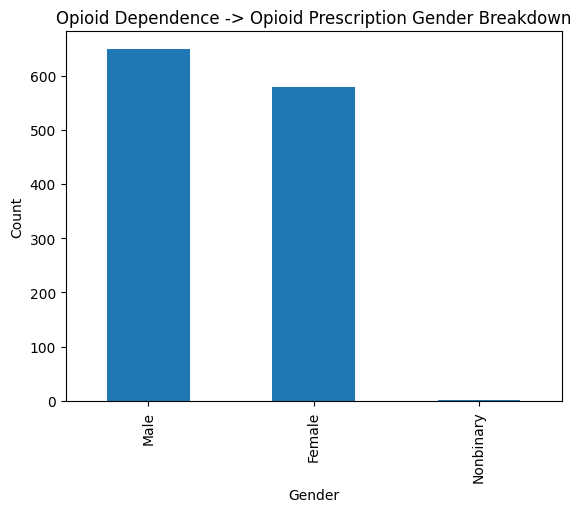

gender_source_value
Male         649
Female       579
Nonbinary      2
Name: count, dtype: int64


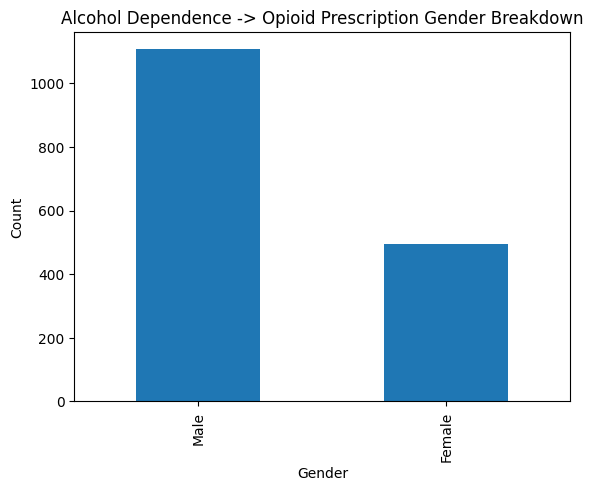

gender_source_value
Male      1106
Female     496
Name: count, dtype: int64


In [20]:
create_dist(opop_patinfo['gender_source_value'], "Opioid Dependence -> Opioid Prescription Gender Breakdown", "Gender")

create_dist(alcop_patinfo['gender_source_value'], "Alcohol Dependence -> Opioid Prescription Gender Breakdown", "Gender")

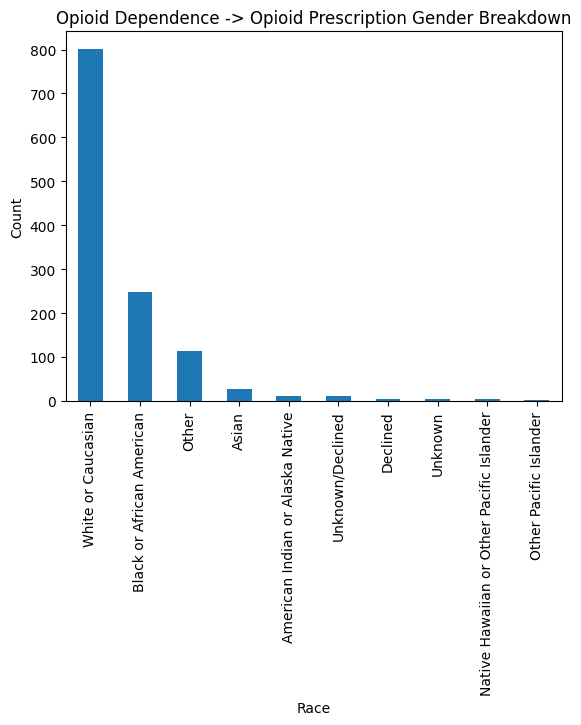

race_source_value
White or Caucasian                           801
Black or African American                    249
Other                                        114
Asian                                         28
American Indian or Alaska Native              11
Unknown/Declined                              11
Declined                                       5
Unknown                                        5
Native Hawaiian or Other Pacific Islander      4
Other Pacific Islander                         2
Name: count, dtype: int64


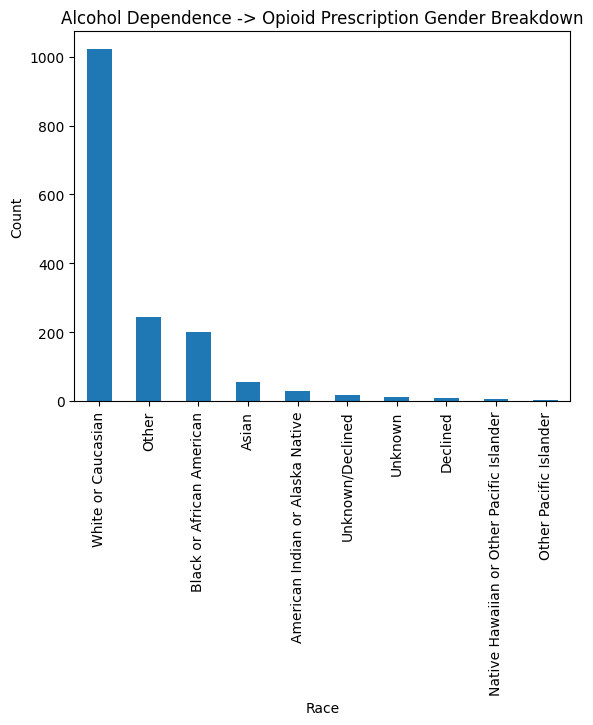

race_source_value
White or Caucasian                           1022
Other                                         245
Black or African American                     201
Asian                                          54
American Indian or Alaska Native               29
Unknown/Declined                               19
Unknown                                        13
Declined                                        9
Native Hawaiian or Other Pacific Islander       7
Other Pacific Islander                          3
Name: count, dtype: int64


In [21]:
create_dist(opop_patinfo['race_source_value'], "Opioid Dependence -> Opioid Prescription Gender Breakdown", "Race")

create_dist(alcop_patinfo['race_source_value'], "Alcohol Dependence -> Opioid Prescription Gender Breakdown", "Race")

Text(0.5, 1.0, 'Opioid to Opioid Age Dist')

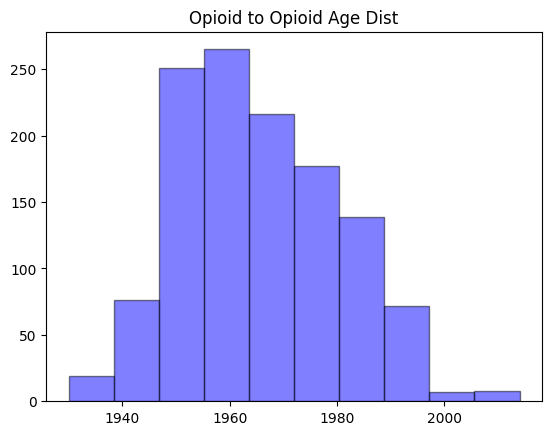

In [22]:
plt.hist(opop_patinfo['year_of_birth'], color='blue', alpha=0.5, bins=10, edgecolor='black')
plt.title(label='Opioid to Opioid Age Dist')


Text(0.5, 1.0, 'Alc to Opioid Age Dist')

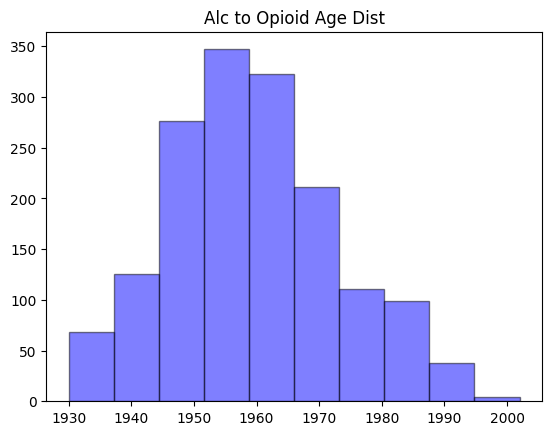

In [23]:
plt.hist(alcop_patinfo['year_of_birth'], color='blue', alpha=0.5, bins=10, edgecolor='black')
plt.title(label='Alc to Opioid Age Dist')

# Check for Other Disease Enrichment